<a href="https://colab.research.google.com/github/danielahernandz/Series-de-tiempo-avanzado/blob/main/ARMA(p%2Cq).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ARMA(p,q)

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
# from statsmodels.tsa.arima_model as ARMA
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
from math import sqrt
import seaborn as sns 
sns.set()

In [2]:
raw_csv_data = pd.read_csv('Index2018.csv')
df_comp = raw_csv_data
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
df_comp.set_index("date", inplace=True)
df_comp = df_comp.asfreq('b')
df_comp = df_comp.fillna(method='ffill')

df_comp['market_value']= df_comp.ftse


del df_comp['spx']
del df_comp['dax']
del df_comp['ftse']
del df_comp['nikkei']

#Datos de train y test
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

##LLR TEST

In [3]:
#Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

def LLR_test(model_1, model_2, DF=1):
  #hallamos las log-verosimilitudes de los modelos para ello usamos el metodo .llf
  L1 = model_1.llf
  L2 = model_2.llf
  LR = (2*(L2-L1)) #Estadistico
  p = chi2.sf(LR, DF).round(3) #distribución del estadistico es una CHI2, por el estadiscito los grado de libertad y se redondea a  decimales.
  return p

##Creating Returns 

In [4]:
df['returns'] = df.market_value.pct_change(1)*100

#ARMA(1,1)

In [5]:
model_ret_arma1= ARIMA(df.returns[1:], order=(1,0,1))
result_arma1 = model_ret_arma1.fit()
print(result_arma1.summary())

#Como usamos retornos es natural que se centren alrededor de 0, es decir que la constante no sea significativa.


#ar.L1: Un coeficiente de más del 75%, sugiere que hay una tendencia positiva entre valores pasados y presentes. esto nos dice la partr autorregresiva.
#ma.L1: Un coeficiente negativo, sugiere que deberiamos estar alejandonos de valores del periodo pasado en lugar de tratar de usarlos como objetivo para calibración. 


                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -7916.500
Date:                Sun, 11 Jun 2023   AIC                          15841.000
Time:                        17:18:12   BIC                          15867.085
Sample:                    01-10-1994   HQIC                         15850.140
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.290      0.197      -0.010       0.048
ar.L1          0.7650      0.045     16.995      0.000       0.677       0.853
ma.L1         -0.8142      0.040    -20.187      0.0

##Comparación de modelos

In [7]:
model_ret_ar1= ARIMA(df.returns[1:], order=(1,0,0))
model_ret_ma1= ARIMA(df.returns[1:], order=(0,0,1))
result_ret_ar1 = model_ret_ar1.fit()
result_ret_ma1 = model_ret_ma1.fit()

In [8]:
print("\nARMA vs AR", LLR_test(result_ret_ar1, result_arma1))
print("\nARMA vs MA", LLR_test(result_ret_ma1, result_arma1)) #ARMA mejor en ambos casos
#Uso de errores pasados junto con valores pasados da mejores estimaciones


ARMA vs AR 0.0

ARMA vs MA 0.0


##Higher-Lag ARMA Models 

Iniciamos con un modelo sobreparametrizado ARMA
Xt= c+ φ1Xt-1 + φ1Xt-2 + θ1Et-1 + θ1Et-2 + θ1Et-3 + εt
Y modelos siguientes estan caracterizados por una disminución de parametros hasta llegar al más simple

El modelo debe cumplir:

1. Todos los coeficientes significativos
2. Alta log-verosimilitd
3. Bajo criterio de información (AIC o BIC)

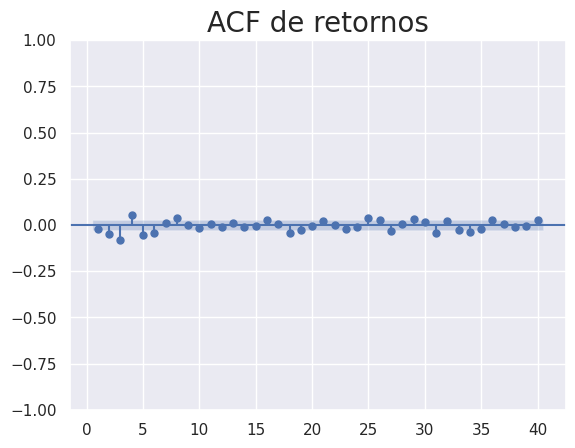

In [9]:
sgt.plot_acf(df.returns[1:], zero= False, lags= 40)
plt.title('ACF de retornos', size=20)
plt.show()

#A lo sumo 8 componentes para MA

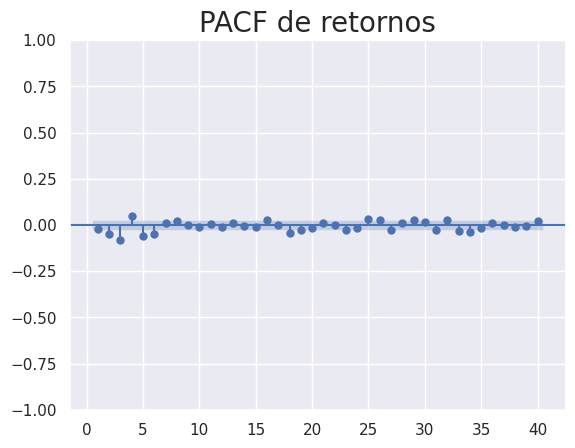

In [10]:
sgt.plot_pacf(df.returns[1:], zero= False, lags= 40, method= 'ols')
plt.title('PACF de retornos', size=20)
plt.show()
#A lo sumo 6 componentes para AR

##Si se considera ARMA(6,8) serpia redundante, por lo que se cancelarian más de la mitad con p-valores no significativos

##ARMA (P,Q)
Si nuestra predicción del modelo Xt fue menor que el valor real X^t obtenemos un valor residual positivo. ET>0 por lo tanto al tomar este valor positivo  multiplicarlo por un coeficiente positivo obtenemos un componente de medias moviles con signo positivo θet>0.

Esto da como resultado un aumento en el valor de nuestras mediciones para el proximo periodo. Es decir se intentaria cerrar la brecha entre el valor real y la predección. Y viseversa en caso de ser el valor predictivo mayor al valor real. Cada periodo de rendimiento positivo viene seguido de uno de rendimiento negativo esto es lo que nos permite mantenernos cerca de la media de cero independientemente del inicio y el final, por ello los modelos ARMA son buenos estimando datos estacionarios. 

In [11]:
modelret_ar3_ma3= ARIMA(df.returns[1:], order=(3,0,3))
result_arma33 = modelret_ar3_ma3.fit()
result_arma33.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(3, 0, 3)   Log Likelihood               -7893.515
Date:                Sun, 11 Jun 2023   AIC                          15803.030
Time:                        18:32:01   BIC                          15855.200
Sample:                    01-10-1994   HQIC                         15821.311
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.281      0.200      -0.010       0.048
ar.L1         -0.1880      0.068     -2.780      0.005      -0.321      -0.055
ar.L2         -0.2926      0.054     -5.380      0.000      -0.399      -0.186
ar.L3          0.4469      0.062      7.252      0.000       0.326       0.568
ma.L1          0.1690      0.063      2.686      0.007       0.046       0.292
ma.L2          0.2260      0.052      4.328      0.000       0.124       0.328
ma.L3         -0.5442      0.056     -9.632      0.000      -0.655      -0.433
sigma2         1.3591      0.015     92.543      0.000       1.330       1.388
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):              6862.43
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               2.00   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
##Si se considera ARMA(6,8) serpia redundante, por lo que usaremos la mitad 3,3
LLR_test(result_arma1, result_arma33, DF= 4)

0.0

In [14]:
modelret_ar3_ma2= ARIMA(df.returns[1:], order=(3,0,2))
result_arma32 = modelret_ar3_ma2.fit()
result_arma32.summary()

#Componentes ma positivos hay ciertos eventos de caibración entre más atras menos influyen los errores

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(3, 0, 2)   Log Likelihood               -7895.747
Date:                Sun, 11 Jun 2023   AIC                          15805.495
Time:                        18:34:12   BIC                          15851.143
Sample:                    01-10-1994   HQIC                         15821.491
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.211      0.226      -0.012       0.049
ar.L1         -0.6778      0.055    -12.298      0.000      -0.786      -0.570
ar.L2         -0.5082      0.063     -8.035      0.000      -0.632      -0.384
ar.L3         -0.1141      0.009    -12.755      0.000      -0.132      -0.097
ma.L1          0.6561      0.056     11.747      0.000       0.547       0.766
ma.L2          0.4468      0.064      7.031      0.000       0.322       0.571
sigma2         1.3604      0.015     91.796      0.000       1.331       1.389
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6513.61
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.99   Skew:                            -0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
modelret_ar2_ma3= ARIMA(df.returns[1:], order=(2,0,3))
result_arma23 = modelret_ar2_ma3.fit()
result_arma23.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(2, 0, 3)   Log Likelihood               -7895.587
Date:                Sun, 11 Jun 2023   AIC                          15805.175
Time:                        18:34:41   BIC                          15850.823
Sample:                    01-10-1994   HQIC                         15821.170
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.015      1.224      0.221      -0.011       0.049
ar.L1         -0.5600      0.057     -9.777      0.000      -0.672      -0.448
ar.L2         -0.4178      0.065     -6.381      0.000      -0.546      -0.289
ma.L1          0.5373      0.057      9.417      0.000       0.425       0.649
ma.L2          0.3531      0.066      5.383      0.000       0.225       0.482
ma.L3         -0.1159      0.009    -12.679      0.000      -0.134      -0.098
sigma2         1.3604      0.015     91.315      0.000       1.331       1.390
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6515.27
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.99   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
modelret_ar3_ma1= ARIMA(df.returns[1:], order=(3,0,1))
result_arma31 = modelret_ar3_ma1.fit()
result_arma31.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(3, 0, 1)   Log Likelihood               -7899.072
Date:                Sun, 11 Jun 2023   AIC                          15810.144
Time:                        19:17:45   BIC                          15849.271
Sample:                    01-10-1994   HQIC                         15823.855
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.248      0.212      -0.011       0.048
ar.L1         -0.5074      0.062     -8.155      0.000      -0.629      -0.385
ar.L2         -0.0638      0.009     -7.027      0.000      -0.082      -0.046
ar.L3         -0.1102      0.008    -13.610      0.000      -0.126      -0.094
ma.L1          0.4836      0.064      7.608      0.000       0.359       0.608
sigma2         1.3623      0.015     92.782      0.000       1.334       1.391
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              6490.60
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               2.00   Skew:                            -0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
modelret_ar2_ma2= ARIMA(df.returns[1:], order=(2,0,2))
result_arma22 = modelret_ar2_ma2.fit()
result_arma22.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -7914.692
Date:                Sun, 11 Jun 2023   AIC                          15841.384
Time:                        19:18:03   BIC                          15880.511
Sample:                    01-10-1994   HQIC                         15855.095
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.290      0.197      -0.010       0.048
ar.L1         -0.0969      0.091     -1.068      0.286      -0.275       0.081
ar.L2          0.6975      0.066     10.509      0.000       0.567       0.828
ma.L1          0.0399      0.092      0.435      0.663      -0.140       0.220
ma.L2         -0.7259      0.071    -10.274      0.000      -0.864      -0.587
sigma2         1.3708      0.014     95.248      0.000       1.343       1.399
===================================================================================
Ljung-Box (L1) (Q):                   4.33   Jarque-Bera (JB):              7237.20
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               2.02   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
modelret_ar1_ma3= ARIMA(df.returns[1:], order=(1,0,3))
result_arma13 = modelret_ar1_ma3.fit()
result_arma13.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(1, 0, 3)   Log Likelihood               -7896.838
Date:                Sun, 11 Jun 2023   AIC                          15805.676
Time:                        19:18:11   BIC                          15844.803
Sample:                    01-10-1994   HQIC                         15819.386
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.265      0.206      -0.010       0.048
ar.L1         -0.4693      0.060     -7.878      0.000      -0.586      -0.353
ma.L1          0.4469      0.060      7.437      0.000       0.329       0.565
ma.L2         -0.0637      0.009     -7.277      0.000      -0.081      -0.047
ma.L3         -0.1182      0.008    -14.693      0.000      -0.134      -0.102
sigma2         1.3610      0.015     92.540      0.000       1.332       1.390
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6401.49
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               2.00   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

En el ejemplo el modelo 3,2 resulta mejor con arma, al calcular con ARIMA el modelo 3,3 es mejor que todos los modelos establecidos. 

#Modelos Anidados

La suma de los parametros totales del modelo complejo debe ser mayor que la suma de parametros totales de modelo más simple. 
1. p1 + q1 > p2, q2 ---> p3q3=6 > p2,q1=3
2. P1 =/> P2 y Q1 =/> Q2




In [31]:
print("\n ARMA(3,2): \tLL = ", result_arma32.llf, "\tAIC = ", result_arma32.aic)
print("\n ARMA(3,3): \tLL = ", result_arma33.llf, "\tAIC = ", result_arma33.aic)}

#Mayor Verosimilitud  y menor AIC o criterio de información. 
#Por ello elegimos 3,3 con un Log-vero mayor y un AIC menor. 


 ARMA(3,2): 	LL =  -7895.747490025735 	AIC =  15805.49498005147

 ARMA(3,3): 	LL =  -7893.515045217398 	AIC =  15803.030090434797


##Residuals for returns

In [32]:
df['residual_arma33'] = result_arma33.resid[1:]

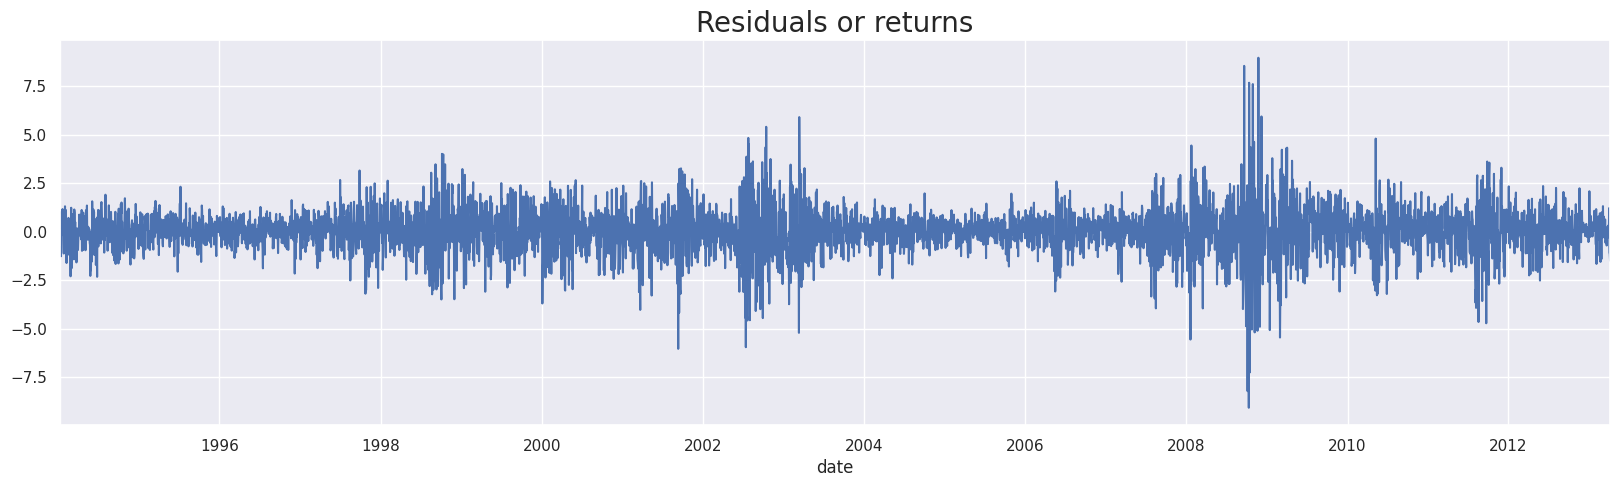

In [33]:
df.residual_arma33.plot(figsize = (20,5))
plt.title('Residuals or returns', size=20)
plt.show()
#Se comportan similar a cuando se realizo por separado ar y ma

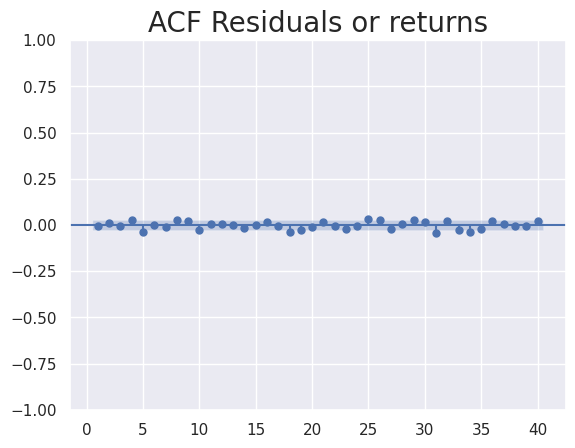

In [34]:
sgt.plot_acf(df.residual_arma33[2:], zero= False, lags= 40)
plt.title('ACF Residuals or returns', size=20)
plt.show()

#el retraso 5 se marca como significativo por ello debemos ahondar

Reevaluating Model Selection

In [35]:
modelret_ar5_ma5= ARIMA(df.returns[1:], order=(5,0,5))
result_arma55 = modelret_ar5_ma5.fit()
result_arma55.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(5, 0, 5)   Log Likelihood               -7882.752
Date:                Sun, 11 Jun 2023   AIC                          15789.504
Time:                        19:45:17   BIC                          15867.758
Sample:                    01-10-1994   HQIC                         15816.925
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0209      0.015      1.408      0.159      -0.008       0.050
ar.L1         -0.0894      0.117     -0.765      0.444      -0.318       0.140
ar.L2         -0.5564      0.081     -6.851      0.000      -0.716      -0.397
ar.L3         -0.1311      0.077     -1.712      0.087      -0.281       0.019
ar.L4          0.2494      0.073      3.408      0.001       0.106       0.393
ar.L5          0.1028      0.090      1.145      0.252      -0.073       0.279
ma.L1          0.0661      0.117      0.567      0.571      -0.162       0.295
ma.L2          0.5060      0.081      6.237      0.000       0.347       0.665
ma.L3          0.0314      0.074      0.426      0.670      -0.113       0.176
ma.L4         -0.2371      0.071     -3.353      0.001      -0.376      -0.099
ma.L5         -0.1971      0.085     -2.310      0.021      -0.364      -0.030
sigma2         1.3544      0.015     90.056      0.000       1.325       1.384
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              6384.35
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.99   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
modelret_ar5_ma1= ARIMA(df.returns[1:], order=(5,0,1))
result_arma51 = modelret_ar5_ma1.fit()
result_arma51.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(5, 0, 1)   Log Likelihood               -7889.311
Date:                Sun, 11 Jun 2023   AIC                          15794.623
Time:                        19:45:24   BIC                          15846.792
Sample:                    01-10-1994   HQIC                         15812.903
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.301      0.193      -0.010       0.047
ar.L1          0.3449      0.105      3.270      0.001       0.138       0.552
ar.L2         -0.0458      0.009     -4.852      0.000      -0.064      -0.027
ar.L3         -0.0651      0.010     -6.435      0.000      -0.085      -0.045
ar.L4          0.0742      0.012      6.092      0.000       0.050       0.098
ar.L5         -0.0813      0.009     -9.480      0.000      -0.098      -0.064
ma.L1         -0.3682      0.106     -3.461      0.001      -0.577      -0.160
sigma2         1.3570      0.015     92.269      0.000       1.328       1.386
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              6468.96
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               2.00   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [49]:
modelret_ar1_ma5= ARIMA(df.returns[1:], order=(1,0,5))
result_arma15 = modelret_ar1_ma5.fit()
result_arma15.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(1, 0, 5)   Log Likelihood               -7890.974
Date:                Sun, 11 Jun 2023   AIC                          15797.949
Time:                        19:56:50   BIC                          15850.118
Sample:                    01-10-1994   HQIC                         15816.230
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.297      0.194      -0.010       0.047
ar.L1          0.3218      0.133      2.415      0.016       0.061       0.583
ma.L1         -0.3467      0.134     -2.593      0.010      -0.609      -0.085
ma.L2         -0.0406      0.010     -4.157      0.000      -0.060      -0.021
ma.L3         -0.0682      0.011     -6.099      0.000      -0.090      -0.046
ma.L4          0.0736      0.015      5.012      0.000       0.045       0.102
ma.L5         -0.0682      0.009     -7.411      0.000      -0.086      -0.050
sigma2         1.3579      0.015     91.599      0.000       1.329       1.387
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6465.72
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               2.00   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [50]:
print("\n ARMA(3,3): \tLL = ", result_arma33.llf, "\tAIC = ", result_arma33.aic)
print("\n ARMA(5,1): \tLL = ", result_arma51.llf, "\tAIC = ", result_arma51.aic)
print("\n ARMA(1,5): \tLL = ", result_arma51.llf, "\tAIC = ", result_arma15.aic)


 ARMA(3,3): 	LL =  -7893.515045217398 	AIC =  15803.030090434797

 ARMA(5,1): 	LL =  -7889.311305453215 	AIC =  15794.62261090643

 ARMA(1,5): 	LL =  -7889.311305453215 	AIC =  15797.948869075708


##Residual for the New Model

In [40]:
df['residual_bestmodel'] = result_arma51.resid[1:]

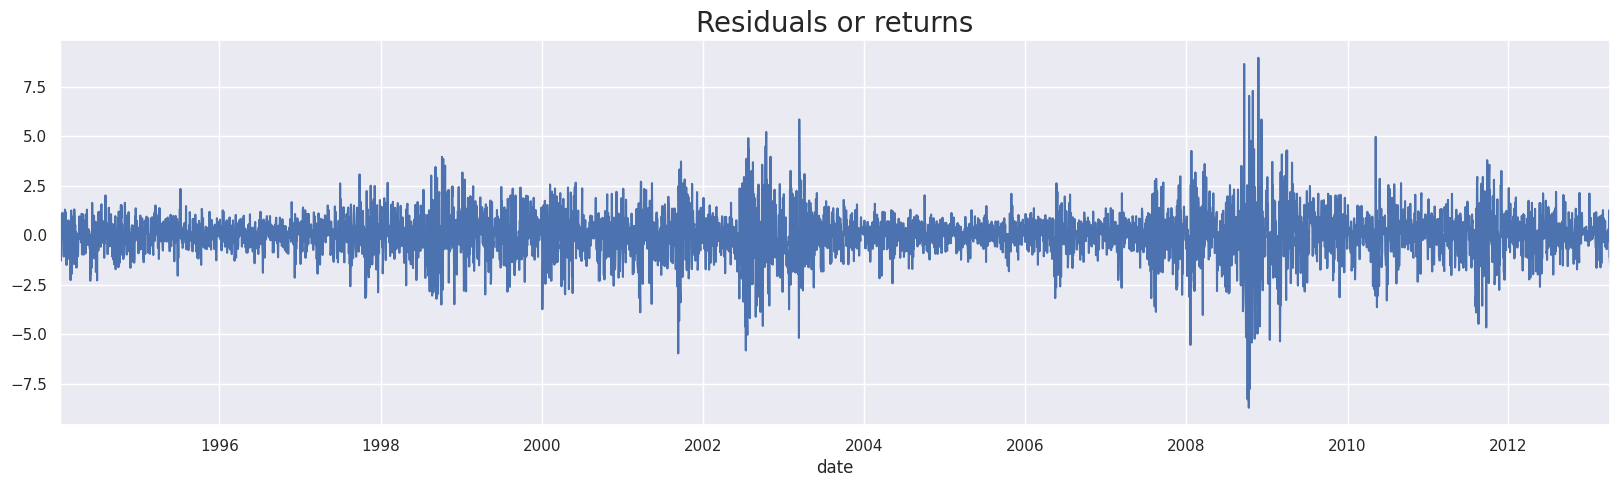

In [42]:
df.residual_bestmodel.plot(figsize = (20,5))
plt.title('Residuals or returns', size=20)
plt.show()

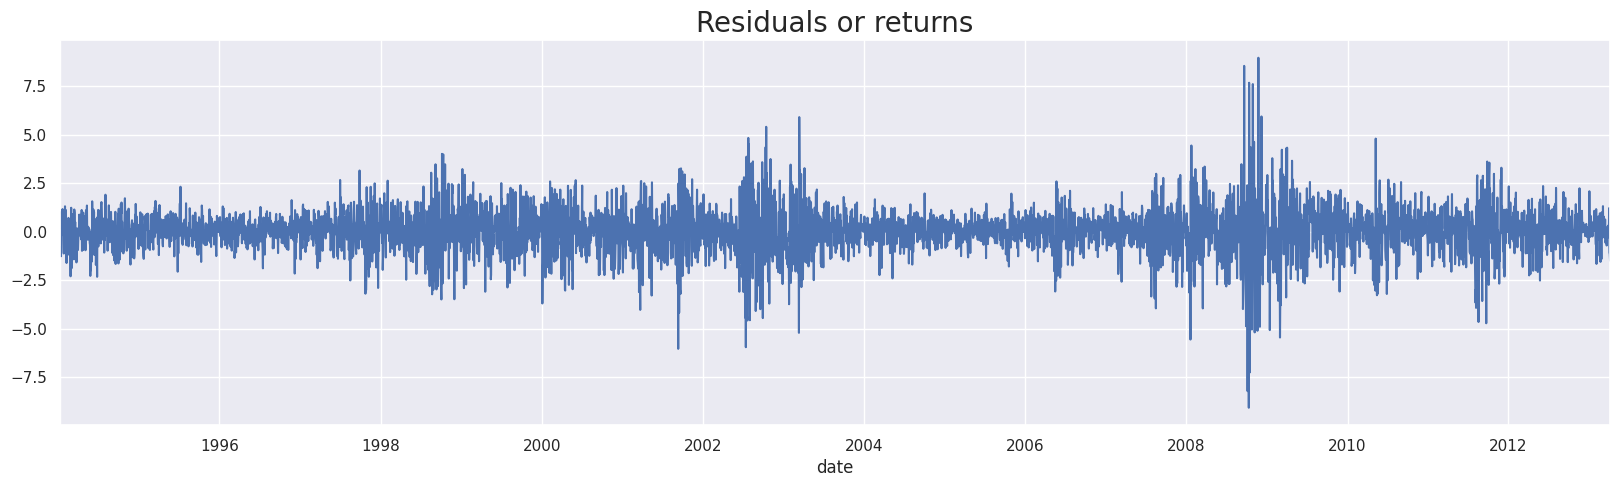

In [43]:
df.residual_arma33.plot(figsize = (20,5))
plt.title('Residuals or returns', size=20)
plt.show()

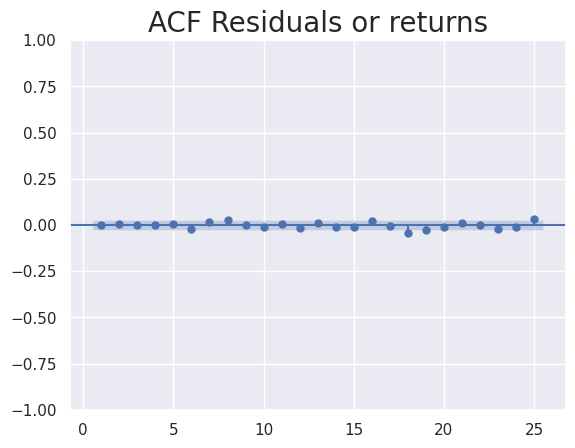

In [54]:
sgt.plot_acf(df.residual_bestmodel[2:], zero= False, lags= 25)
plt.title('ACF Residuals or returns', size=20)
plt.show()


#ARIMA Models for prices

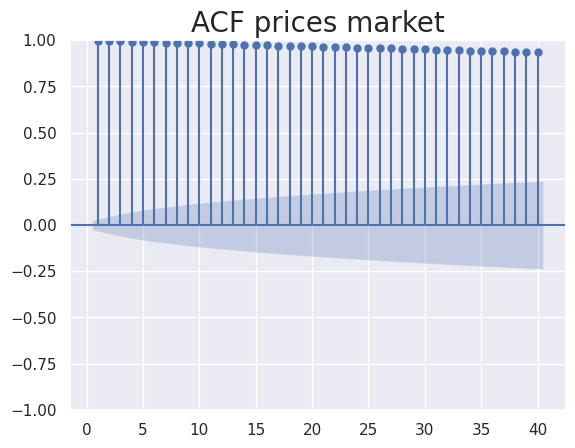

In [59]:
sgt.plot_acf(df.market_value, unbiased= False, zero= False, lags= 40)
plt.title('ACF prices market', size=20)
plt.show()

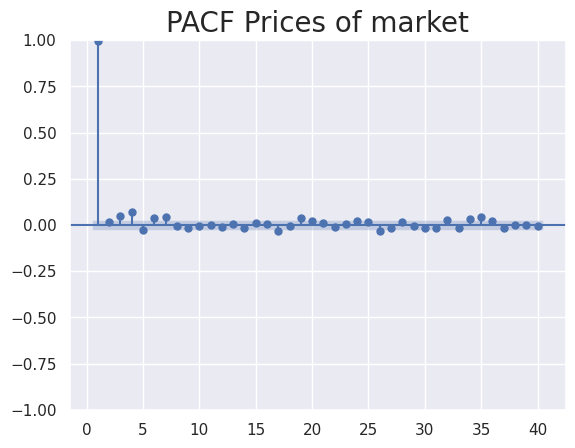

In [64]:
sgt.plot_pacf(df.market_value, lags= 40, alpha= 0.05, zero= False, method= ('ols'))
plt.title('PACF Prices of market', size=20)
plt.show()

In [68]:
modelo_arma11 = ARIMA(df.market_value, order=(1,0,1))
resultado_arma11 = modelo_arma11.fit()
resultado_arma11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -27621.875
Date:                Sun, 11 Jun 2023   AIC                          55251.749
Time:                        20:14:57   BIC                          55277.835
Sample:                    01-07-1994   HQIC                         55260.890
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6409    366.501     13.887      0.000    4371.312    5807.970
ar.L1          0.9982      0.001   1189.159      0.000       0.997       1.000
ma.L1         -0.0186      0.010     -1.894      0.058      -0.038       0.001
sigma2      3510.8350     41.068     85.489      0.000    3430.344    3591.326
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3280.53
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.89   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [99]:
df['residuosmarket'] = resultado_arma11.resid

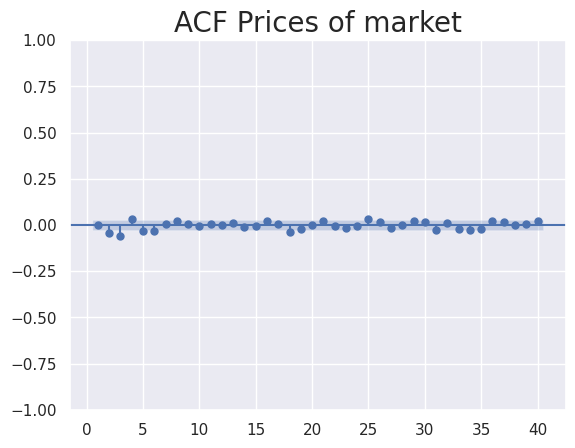

In [101]:
sgt.plot_acf(df.residuosmarket, lags= 40, zero= False)
plt.title('ACF Prices of market', size=20)
plt.show()

#Observamos que 6 retrasos estan bien

In [70]:
modelo_arma61 = ARIMA(df.market_value, order=(6,0,1))
resultado_arma61 = modelo_arma61.fit()
resultado_arma61.summary()
#1 no signi

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(6, 0, 1)   Log Likelihood              -27594.195
Date:                Sun, 11 Jun 2023   AIC                          55206.390
Time:                        20:19:22   BIC                          55265.082
Sample:                    01-07-1994   HQIC                         55226.956
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6310    525.543      9.685      0.000    4059.586    6119.676
ar.L1          1.3884      0.158      8.793      0.000       1.079       1.698
ar.L2         -0.4332      0.154     -2.812      0.005      -0.735      -0.131
ar.L3         -0.0103      0.017     -0.619      0.536      -0.043       0.022
ar.L4          0.1125      0.016      6.905      0.000       0.081       0.144
ar.L5         -0.1154      0.020     -5.695      0.000      -0.155      -0.076
ar.L6          0.0573      0.009      6.193      0.000       0.039       0.075
ma.L1         -0.4089      0.158     -2.582      0.010      -0.719      -0.098
sigma2      3471.4062     42.110     82.437      0.000    3388.873    3553.940
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              3031.82
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.89   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# modelo_arma66 = ARIMA(df.market_value, order=(6,0,6))
# resultado_arma66 = modelo_arma66.fit()
# resultado_arma66.summary()
#NO FUNCIONA SOBREESTIMADO REDUNDANTE SE CANCELAN EFECTOS. 
#CON 5AR resagos sea cual sea 3 no sinificativos

# modelo_arma56 = ARIMA(df.market_value, order=(6,0,5)) o, 5,6 nada. no sirve
# resultado_arma56 = modelo_arma56.fit()
# resultado_arma56.summary()
#solo 1 !!significativo. 

# modelo_arma71 = ARIMA(df.market_value, order=(7,0,1))
# resultado_arma71 = modelo_arma71.fit()
# resultado_arma71.summary()

#mas de 3 no signi

In [ ]:
modelo_arma15 = ARIMA(df.market_value, order=(1,0,5))
resultado_arma15 = modelo_arma15.fit()
resultado_arma15.summary()
#Todos significativos

In [ ]:
modelo_arma14 = ARIMA(df.market_value, order=(1,0,4))
resultado_arma14 = modelo_arma14.fit()
resultado_arma14.summary()
#Todos significativos menos 1

In [ ]:
modelo_arma16 = ARIMA(df.market_value, order=(1,0,6))
resultado_arma16 = modelo_arma16.fit()
resultado_arma16.summary()
#1 NO SIGNI

In [108]:
modelo_arma42 = ARIMA(df.market_value, order=(4,0,2)) 
resultado_arma42 = modelo_arma42.fit()
resultado_arma42.summary()
#1 NO SIGNI con 4,3 pero mejor con 4,2

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(4, 0, 2)   Log Likelihood              -27606.750
Date:                Sun, 11 Jun 2023   AIC                          55229.500
Time:                        20:49:24   BIC                          55281.671
Sample:                    01-07-1994   HQIC                         55247.781
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6403    486.509     10.462      0.000    4136.101    6043.180
ar.L1          0.6104      0.078      7.795      0.000       0.457       0.764
ar.L2          0.9224      0.036     25.485      0.000       0.851       0.993
ar.L3         -0.5855      0.078     -7.508      0.000      -0.738      -0.433
ar.L4          0.0517      0.011      4.558      0.000       0.029       0.074
ma.L1          0.3664      0.077      4.744      0.000       0.215       0.518
ma.L2         -0.6035      0.078     -7.758      0.000      -0.756      -0.451
sigma2      3488.3516     41.729     83.596      0.000    3406.565    3570.138
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3204.10
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.90   Skew:                            -0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
modelo_arma35 = ARIMA(df.market_value, order=(3,0,5))
resultado_arma35 = modelo_arma35.fit()
resultado_arma35.summary()
#Todos significativos menos 1

In [102]:
modelo_arma62 = ARIMA(df.market_value, order=(6,0,2))
resultado_arma62 = modelo_arma62.fit()
resultado_arma62.summary()
#Todos significativos

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(6, 0, 2)   Log Likelihood              -27590.600
Date:                Sun, 11 Jun 2023   AIC                          55201.200
Time:                        20:43:58   BIC                          55266.414
Sample:                    01-07-1994   HQIC                         55224.052
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6408   1477.152      3.446      0.001    2194.476    7984.805
ar.L1          1.1942      0.051     23.416      0.000       1.094       1.294
ar.L2         -1.0585      0.070    -15.022      0.000      -1.197      -0.920
ar.L3          0.7823      0.047     16.604      0.000       0.690       0.875
ar.L4          0.0841      0.018      4.544      0.000       0.048       0.120
ar.L5         -0.0940      0.015     -6.108      0.000      -0.124      -0.064
ar.L6          0.0913      0.010      9.218      0.000       0.072       0.111
ma.L1         -0.2148      0.050     -4.333      0.000      -0.312      -0.118
ma.L2          0.8216      0.045     18.158      0.000       0.733       0.910
sigma2      3477.2538     42.352     82.104      0.000    3394.246    3560.261
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3014.73
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.89   Skew:                            -0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [109]:
print("\n ARMA(6,2): \tLL = ", resultado_arma62.llf, "\tAIC = ", resultado_arma62.aic)
print("\n ARMA(1,5): \tLL = ", resultado_arma15.llf, "\tAIC = ", resultado_arma15.aic)
print("\n ARMA(4,2): \tLL = ", resultado_arma15.llf, "\tAIC = ", resultado_arma42.aic)
# print("\n ARMA(1,4): \tLL = ", resultado_arma14.llf, "\tAIC = ", resultado_arma14.aic)# print("\n ARMA(4,2): \tLL = ", resultado_arma42.llf, "\tAIC = ", resultado_arma42.aic)# print("\n ARMA(1,1): \tLL = ", resultado_arma11.llf, "\tAIC = ", resultado_arma11.aic)


 ARMA(6,2): 	LL =  -27590.599979404935 	AIC =  55201.19995880987

 ARMA(1,5): 	LL =  -27596.360532947976 	AIC =  55208.72106589595

 ARMA(4,2): 	LL =  -27596.360532947976 	AIC =  55229.50016096279


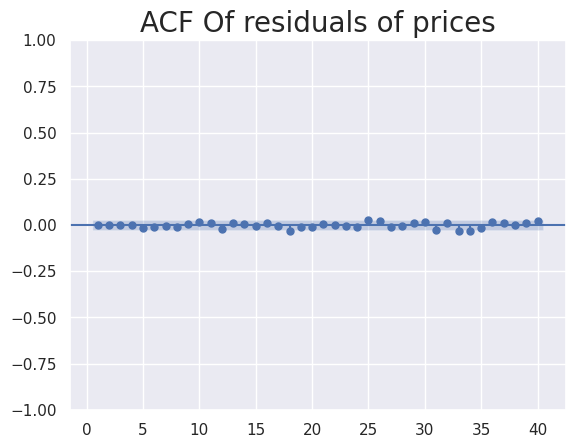

In [110]:
df['residuos_arma62']= resultado_arma62.resid
sgt.plot_acf(df.residuos_arma62, zero= False, lags=40)
plt.title("ACF Of residuals of prices", size=20)
plt.show()

##ARMA for Returns vs ARMA for prices

In [111]:
print("\n ARMA(6,2): \tLL = ", resultado_arma62.llf, "\tAIC = ", resultado_arma62.aic)
print("\n ARMA(5,1): \tLL = ", result_arma51.llf, "\tAIC = ", result_arma51.aic)

#Se prefiere con retornos ya que los datos de precios normales no son estacionarios, y al convertirlos en retornos modelamos ya una serie estacionaria. 


 ARMA(6,2): 	LL =  -27590.599979404935 	AIC =  55201.19995880987

 ARMA(5,1): 	LL =  -7889.311305453215 	AIC =  15794.62261090643
